<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 

     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 8.2 MB 56.6 MB/s 


## Dataset

Посмотрим на то, как устроен датасет

In [3]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [4]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [5]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [6]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [7]:
!pip install youtokentome

     |████████████████████████████████| 1.7 MB 7.6 MB/s 


In [8]:
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [9]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [10]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Составление батчей

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))] # list of 0 and 1
                
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            tensor_outputs = torch.zeros((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)
            tensor_outputs = tensor_outputs + 2
            # tensor_outputs =  torch.full((self.batch_size, max_sentences), dtype=torch.float32, device=self.device, fill_value = 2)

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [13]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2. 
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion не одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбираете предложения, у которых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [14]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# from torch.nn.utils.rnn import pack_padded_sequence as pack
# from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.num_directions = num_directions

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1) # vector hj @ vector Wc -> scalar
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2) # document representation, vector [hfj, hbj] @ matrix Wd -> vector d
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2) # vector d @ matrix Ws -> vector, в forward еще домножим на hj^T, и будет scalar 
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2) # vector sj @ matrix Wr -> vector, в forward еще домножим на hj^T, и будет scalar 
        self.tanh_layer = nn.Tanh()
        self.sigmoid_layer = nn.Sigmoid()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1) # seq num
        tokens_count = inputs.size(2) # seq_len
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        # -h^T * W * tanh(s)
        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience # [batch_size, seq num]
            
            # 0) initialize summary_representation and novelty by zeros
            # YOUR CODE
            summary_representation = torch.zeros((batch_size, self.hidden_size * self.num_directions)).to(device) # для каждого документа
            novelty = torch.zeros((batch_size, sentences_count)).to(device) # для каждого предложения

            for sentence_num in range(sentences_count):

                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                sentence_num_state = outputs[:, sentence_num, :].unsqueeze(1) 
                # hj: [batch_size, seq num, hidden_size] -> [batch_size, hidden_size] -> [batch_size, 1, hidden_size] [32, 1, 256]

                # 2) calculate novelty for current sentence
                # part_novelty = self.tanh_layer(self.novelty_linear_layer(summary_representation))
                part_novelty = self.novelty_linear_layer(self.tanh_layer(summary_representation)).unsqueeze(2)
                # [batch_size, hidden_size] -> [batch_size, hidden_size, 1] [32, 256, 1]
                current_novelty = -torch.bmm(sentence_num_state, part_novelty).squeeze(2)
                # [batch_size, 1, 1] -> [batch_size, 1] [32, 1] - для текущего предложения

                # 3) add novelty to predictions
                # 4) calculcate probability for current sentence
                probability = self.sigmoid_layer(predictions[:, sentence_num].unsqueeze(1) + current_novelty)
                # [batch_size, 1] [32, 1]

                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation
                current_sum_repr = torch.bmm(probability.unsqueeze(2), sentence_num_state).squeeze(1)
                # [batch_size, 1, 1] @ [batch_size, 1, hidden_size] -> [batch_size, 1, hidden_size] -> [batch_size, hidden_size]
                summary_representation = summary_representation + current_sum_repr
                # [batch_size, hidden_size]

                novelty[:, sentence_num] = current_novelty.squeeze(1)

        return content + salience + novelty  # [batch_size, seq num]

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [15]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
# # model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [16]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [17]:
# !gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py
import train_model_summary
import imp 
imp.reload(train_model_summary)
from train_model_summary import train_with_logs

In [18]:
def class_weights(records):
    outputs = 0
    len_outputs = 0
    for record in records:
        sentences = record['sentences']
        sentences_indicies = record['oracle_sentences']
        output = [int(i in sentences_indicies) for i in range(len(sentences))] # список 0 и 1
        len_outputs += len(output)
        output = np.sum(output) # число элементов класса 1
        outputs += output
    
    n_0 = outputs / len_outputs
    n_1 = 1 - outputs / len_outputs
    weights = torch.tensor([n_0, n_1], dtype=torch.float32)    
    return weights 

In [19]:
weights = class_weights(ext_train_records)
weights 

tensor([0.0769, 0.9231])

In [20]:
def train(model, use_class_weights, N_EPOCHS, CLIP, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        # YOUR CODE
        weights = class_weights(ext_train_records).to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=2, weight=weights)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=2)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

## Inference

In [21]:
from train_model_summary import punct_detokenize, postprocess

def inference_summarunner(model, iterator, top_k, threshold):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs']) # [batch_size, seq num]

        if top_k:
          sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
          # [batch_size, индексы 3 предложений с наибольшими логитами в порядке возрастания]
        
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()

            if top_k:
                pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]]) 
                # .sort[0] - список номеров предложений, а .sort[1] - список индексов 
            else:
                sum_in = torch.nonzero(logits[i] > threshold, as_tuple=True)[0]
                # torch.nonzero(x, as_tuple=True) - Возвращает кортеж одномерных тензоров, по одному для каждого измерения в input, 
                # каждый из которых содержит индексы (в этом измерении) всех ненулевых элементов input
                # >>> torch.nonzero(torch.tensor([1, 1, 1, 0, 1]))
                #     tensor([[ 0],
                #             [ 1],
                #             [ 2],
                #             [ 4]])
                # sentences = batch['records'][i]['sentences']
                sentences = batch['records'][i]['sentences']
                pred_summary = ' '.join([sentences[ind] for ind in sum_in if ind < len(sentences)])

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

Модель_1:
* без novelty 
* без весов в CrossEntropyLoss

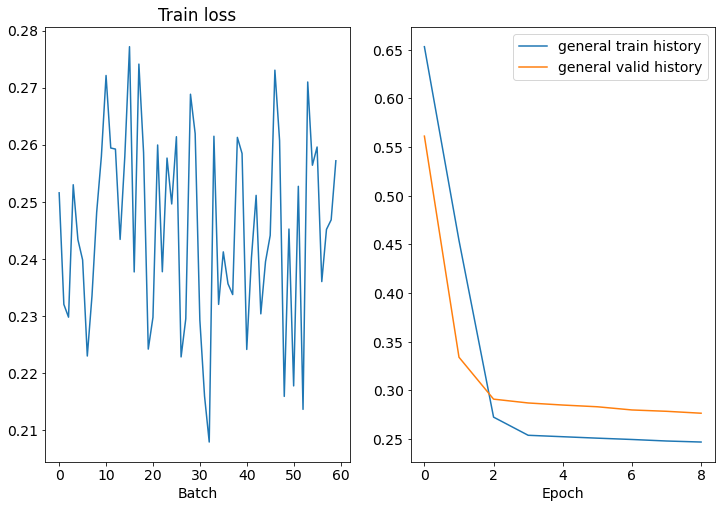

Epoch: 10 | Time: 0m 8s
	Train Loss: 0.246 | Train PPL:   1.279
	 Val. Loss: 0.274 |  Val. PPL:   1.316


In [23]:
model_1 = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
train(model_1, False, N_EPOCHS=10, CLIP=1, lr=1e-5)

In [24]:
model_1.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_1, test_iterator, top_k=3, threshold=None)

# BLEU:  0.4483358093852308
# ROUGE:  {'rouge-1': {'f': 0.317331812475369, 'p': 0.30313415143950323, 'r': 0.3531967563454289}, 
#          'rouge-2': {'f': 0.14277322190268438, 'p': 0.13475932187114895, 'r': 0.16339726182715178}

Count: 256
Ref: на этой неделе состоится очередная « черная пятница » — время диких распродаж . однако продавцы придумали очень много уловок , как заставить купить лишнее . в роспотребнадзоре советуют россиянам проверять цены на товары до начала сезона массовых скидок . не исключено , что перед распродажей стоимость искусственно завысили , а потом опустили до обычной .
Hyp: в преддверии очередных распродаж роспотребнадзор на своем сайте дал советы россиянам , как не попасться на трюки продавцов . очередные акции в рамках « черной пятницы » ожидаются 29 ноября . в ведомстве предупреждают , что слишком низкая цена может быть признаком подделки .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.317331812475369, 'p': 0.30313415143950323, 'r': 0.3531967563454289}, 'rouge-2': {'f': 0.14277322190268438, 'p': 0.13475932187114895, 'r': 0.16339726182715178}, 'rouge-l': {'f': 0.2715462303275748, 'p': 0.2739258120398611, 'r': 0.3186041265424389}}


In [31]:
inference_summarunner(model_1, test_iterator, top_k=None, threshold=-1)

# threshold=-0.7
# BLEU:  0.3499424801339186
# ROUGE:  {'rouge-1': {'f': 0.29476853765758354, 'p': 0.413758020887657, 'r': 0.2608015612906056}, 
#          'rouge-2': {'f': 0.13977614653433676, 'p': 0.20740220845095092, 'r': 0.12425970812525651}

# threshold=-0.8
# BLEU:  0.42978272064329415
# ROUGE:  {'rouge-1': {'f': 0.3091599594389451, 'p': 0.3722220316996672, 'r': 0.2958081580153784}, 
#          'rouge-2': {'f': 0.14363431961675607, 'p': 0.17976505888071828, 'r': 0.1376978901699942}

# threshold=-0.9 - MAX
# BLEU:  0.4570086890344996
# ROUGE:  {'rouge-1': {'f': 0.3070905510375507, 'p': 0.33363004046982014, 'r': 0.31718559862006407}, 
#          'rouge-2': {'f': 0.13992974937294073, 'p': 0.1542542644154941, 'r': 0.14694938004773525}

# threshold=-1
# BLEU:  0.41530041844140325
# ROUGE:  {'rouge-1': {'f': 0.3079819161292746, 'p': 0.306691874641566, 'r': 0.34792697816916957}, 
#          'rouge-2': {'f': 0.13781349397292814, 'p': 0.1376580769000347, 'r': 0.16017776671492848}

Count: 256
Ref: следователи в калужской области расследуют дело о доведении до самоубийства 21-летнего военнослужащего сергея сафонова , тело которого нашли в кабинете командира части . родственники солдата уверены , что его убили , поскольку тело было посмертно загримировано . независимая экспертиза обнаружила под гримом на лице погибшего синяки , а на груди и руках – гематомы и ссадины , « которые могут свидетельствовать о борьбе » .
Hyp: в воинской части в козельске калужской области погиб 21-летний солдат-срочник сергей сафонов – его тело обнаружили в кабинете командира части . по факту трагедии военное следственное управление скр по ракетным войскам стратегического назначения ( рвсн ) возбудило уголовное дело по ст . 110 ук рф « доведение до самоубийства » . основанием для этого стало заключение калужского областного бюро судебно-медицинских экспертиз , согласно которому причиной смерти сафонова стала « асфиксия » .
BLEU:  0.41530041844140325
ROUGE:  {'rouge-1': {'f': 0.3079819161

Модель_2:
* с novelty 
* без весов в CrossEntropyLoss

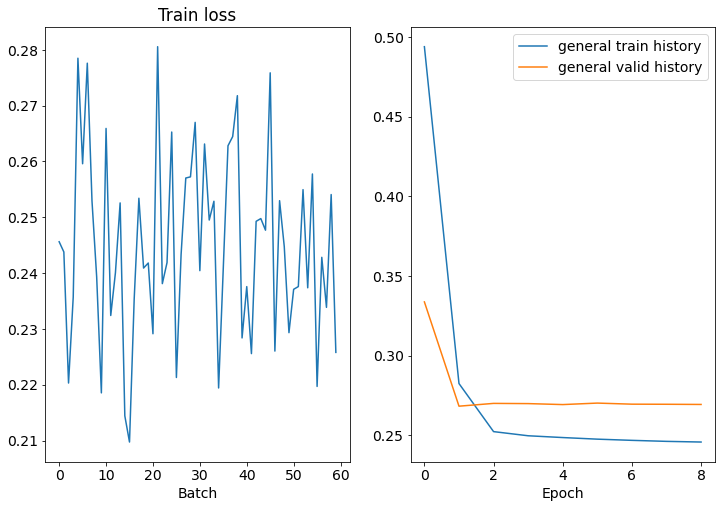

Epoch: 10 | Time: 0m 9s
	Train Loss: 0.245 | Train PPL:   1.278
	 Val. Loss: 0.269 |  Val. PPL:   1.309


In [32]:
model_2 = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)
train(model_2, False, N_EPOCHS=10, CLIP=1, lr=1e-5)

In [33]:
model_2.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_2, test_iterator, top_k=3, threshold=None)

# BLEU:  0.4483358093852308
# ROUGE:  {'rouge-1': {'f': 0.3173318124753689, 'p': 0.30313415143950306, 'r': 0.3531967563454291}, 
#          'rouge-2': {'f': 0.14277322190268438, 'p': 0.1347593218711489, 'r': 0.16339726182715178}

Count: 256
Ref: в преддверии президентских выборов 2020 года дональд трамп неустанно напоминает о своих достижениях за три года управления страной . успехи , конечно , впечатляющие , но многими из них глава сша обязан своему предшественнику бараку обаме , который нередко становится объектом критики со стороны нынешнего лидера .
Hyp: в 2020 год президент сша дональд трамп вошел с лучшими за долгое время рейтингами одобрения . несмотря на скандалы , связанные с процессом импичмента , авторитет лидера вырос — опрос abc news и washington post показал , что 44 % американцев поддерживают политику действующего президента , а в сфере экономики этот показатель и вовсе достиг 56 % . в этом году трамп надеется переизбраться на второй срок , а потому регулярно напоминает о своих достижениях на посту президента .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.3173318124753689, 'p': 0.30313415143950306, 'r': 0.3531967563454291}, 'rouge-2': {'f': 0.14277322190268438, 'p': 0.1347593218711489, '

In [47]:
inference_summarunner(model_2, test_iterator, top_k=None, threshold=-0.451)

# threshold=-0.5
# BLEU:  0.43667696162222236
# ROUGE:  {'rouge-1': {'f': 0.31147201422953247, 'p': 0.3082124764709252, 'r': 0.3459065477116978}, 
#          'rouge-2': {'f': 0.13963176845078265, 'p': 0.13770675928850162, 'r': 0.15906750310364767}

# threshold=-0.6
# BLEU:  0.38182147098246744
# ROUGE:  {'rouge-1': {'f': 0.30897038879621475, 'p': 0.27838971547465535, 'r': 0.3824060646948633}, 
#          'rouge-2': {'f': 0.1362544714319801, 'p': 0.12123010762668746, 'r': 0.17562334884877176}

# threshold=-0.4
# BLEU:  0.4381023541514202
# ROUGE:  {'rouge-1': {'f': 0.311561301260402, 'p': 0.3558574814148385, 'r': 0.2992752370375218}, 
#          'rouge-2': {'f': 0.14445174740749195, 'p': 0.1685957672592269, 'r': 0.13922833704978518}

# threshold=-0.3
# BLEU:  0.23812185637560082
# ROUGE:  {'rouge-1': {'f': 0.28663192918741487, 'p': 0.4513868216281276, 'r': 0.22720018821404414}, 
#          'rouge-2': {'f': 0.13941209820238415, 'p': 0.2321053861813805, 'r': 0.10954423438783188}

# threshold=-0.451 - MAX - threshold сместился немного ближе к 0 по сравнению с моделью без novelty
# BLEU:  0.4635806690434093
# ROUGE:  {'rouge-1': {'f': 0.3091350907308352, 'p': 0.33240345505004415, 'r': 0.3196513043942452}, 
#          'rouge-2': {'f': 0.1414146609055975, 'p': 0.15421190405137852, 'r': 0.14845312931073404}

Count: 256
Ref: госдума приняла во втором чтении законопроект о поддержке отечественных производителей вина . задача депутатов — поддержать добросовестных виноделов и наказать тех , кто производит вино из низкосортных импортных виноматериалов . это сложнейшая задача для законодателя , поскольку и те , кто работает добросовестно , и те , кто выпускает алкоголь сомнительного качества , считаются отечественными производителями .
Hyp: во вторник , 17 декабря , госдума приняла во втором чтении законопроект о продлении до 1 января 2023 года переходного периода для крымских виноделов . законопроект устанавливает особенности производства и оборота этилового спирта , алкогольной и спиртосодержащей продукции в крыму и севастополе . крымские производители спиртного будут обязаны до указанной даты оснастить технологическое оборудование приборами измерения и учета готовой продукции и оформить в собственность или в аренду производственные мощности для изготовления вина .
BLEU:  0.4635806690434093
RO

Модель_3:
* без novelty 
* с весами в CrossEntropyLoss



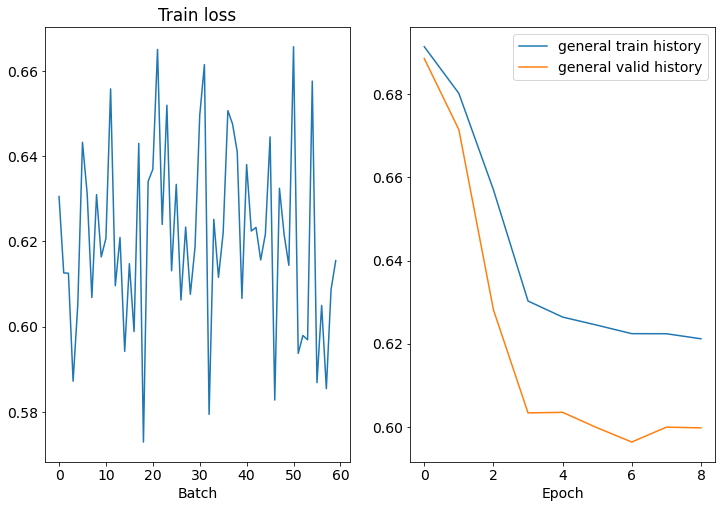

Epoch: 10 | Time: 0m 8s
	Train Loss: 0.620 | Train PPL:   1.859
	 Val. Loss: 0.599 |  Val. PPL:   1.820


In [48]:
model_3 = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
train(model_3, True, N_EPOCHS=10, CLIP=1, lr=1e-5)

In [49]:
model_3.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_3, test_iterator, top_k=3, threshold=None)

# BLEU:  0.4483358093852308
# ROUGE:  {'rouge-1': {'f': 0.31733181247536896, 'p': 0.3031341514395033, 'r': 0.35319675634542913}, 
#          'rouge-2': {'f': 0.1427732219026844, 'p': 0.13475932187114897, 'r': 0.16339726182715172}

Count: 256
Ref: покупка анкарой у москвы зенитных ракетных систем с-400 и проведение турецкой стороной военной операции в сирии под названием « источник мира » , вероятно , станут причиной санкций в отношении турции со стороны сша . комитет сената одобрил законопроект о введении ограничений . парламентарии сша считают , что действия турции в последний год « вышли за рамки дозволенного » .
Hyp: комитет сената сша по международным отношениям принял законопроект о введении санкций в отношении турции , причиной этого названа покупка анкарой у москвы зенитных ракетных систем с-400 и проведение турецкой стороной военной операции в сирии под названием « источник мира » . об этом рассказал американский сенатор роберт менендес на своей странице в twitter « действия турции в последний год действительно вышли за рамки дозволенного . этот законопроект ясно даст им понять , что такие действия в сирии неприемлемы , а покупка системы с-400 недопустима » , — пояснил политик .
BLEU:  0.4483358093852308

In [81]:
inference_summarunner(model_3, test_iterator, top_k=None, threshold=0.4613)

# threshold=0.2
# BLEU:  0.36227324876559175
# ROUGE:  {'rouge-1': {'f': 0.31230971653591155, 'p': 0.2664104590954973, 'r': 0.4093459076257815}, 
#          'rouge-2': {'f': 0.13595611315111872, 'p': 0.11315700066259535, 'r': 0.18943840068133996}

# threshold=0.5
# BLEU:  0.4534097252347468
# ROUGE:  {'rouge-1': {'f': 0.3103977923744604, 'p': 0.3480486332296393, 'r': 0.3029218802992194}, 
#          'rouge-2': {'f': 0.14407305543519439, 'p': 0.16338620538069054, 'r': 0.14250283330364036}

# threshold=0.4613 - MAX - - threshold сместился в положительную сторону по сравнению с моделью без весом у лосса 
# BLEU:  0.48273751122160485
# ROUGE:  {'rouge-1': {'f': 0.31375154684214296, 'p': 0.335958192903838, 'r': 0.31901500501873964}, 
#          'rouge-2': {'f': 0.14447485197822246, 'p': 0.15646469258066334, 'r': 0.14934646680694125}

Count: 256
Ref: в сша обнародовали документы об украинском националисте степане бандере , согласно которым в годы второй мировой войны он работал на гитлера . это указано в статье американского издания , датированной 1951 годом . в материале подчеркивается , что бандера стал организатором этнических чисток , жертвами которых стали десятки тысяч украинцев , поляков и евреев .
Hyp: центральное разведывательное управление ( цру ) сша обнародовало рассекреченные архивные документы о второй мировой войне и украинском националисте степане бандере . на сайте цру появилась четырехстраничная статья из журнала « социалистический вестник » , который издавался в сша в 1921—1965 годах .
BLEU:  0.48273751122160485
ROUGE:  {'rouge-1': {'f': 0.31375154684214324, 'p': 0.3359581929038382, 'r': 0.31901500501873975}, 'rouge-2': {'f': 0.14447485197822246, 'p': 0.15646469258066326, 'r': 0.1493464668069413}, 'rouge-l': {'f': 0.2653825595973773, 'p': 0.3026819271638248, 'r': 0.2875413219153103}}


Модель_4:
* с novelty 
* с весами в CrossEntropyLoss

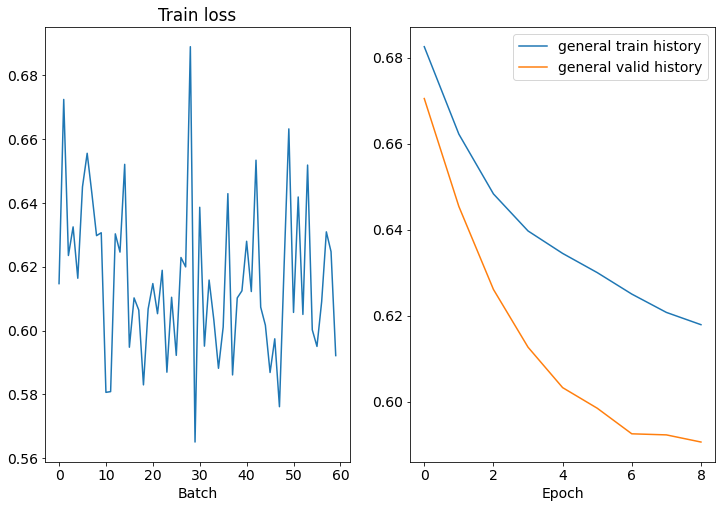

Epoch: 10 | Time: 0m 9s
	Train Loss: 0.616 | Train PPL:   1.852
	 Val. Loss: 0.589 |  Val. PPL:   1.803


In [82]:
model_4 = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)
train(model_4, True, N_EPOCHS=10, CLIP=1, lr=1e-5)

In [83]:
model_4.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_4, test_iterator, top_k=3, threshold=None)

# BLEU:  0.4483358093852308
# ROUGE:  {'rouge-1': {'f': 0.3173318124753688, 'p': 0.3031341514395033, 'r': 0.35319675634542924}, 
#          'rouge-2': {'f': 0.14277322190268443, 'p': 0.134759321871149, 'r': 0.16339726182715167}

Count: 256
Ref: американская телевизионная знаменитость сделала крупные татуировки на лбу — она запечатлела имена своих двоих детей , — но не встретилась с пониманием общественности . это случилось через неделю после того , как отвечать критикам пришлось сыну супермодели синди кроуфорд , успешному манекенщику пресли герберу — он вытатуировал под глазом слово « неправильно понятый » и подвергся осуждению общественности .
Hyp: модель и телевизионная знаменитость америки эмбер роуз , известная своим экстравагантным поведением , в очередной раз удивила публику нестандартным поступком . женщина , которая зарабатывает лицом , сделала на лбу две татуировки , о чем гордо рассказала в своем instagram . теперь на лбу у эмбер роуз навсегда крупно написано курсивом « бэш » и « слэш » , это имена двоих детей 36-летней модели , семилетнего себастиена тейлора томаса и малыша по имени слэш электрик , который родился в октябре 2019 года .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.3173318124

In [105]:
inference_summarunner(model_4, test_iterator, top_k=None, threshold=0.526)

# threshold=0.5
# BLEU:  0.47190982883033844
# ROUGE:  {'rouge-1': {'f': 0.31651199574210365, 'p': 0.3239826220953002, 'r': 0.33274268569833276},
#          'rouge-2': {'f': 0.14448593972341747, 'p': 0.14793134023067722, 'r': 0.1555500958232655}

# threshold=0.6
# BLEU:  0.4243613567623662
# ROUGE:  {'rouge-1': {'f': 0.31079646700337027, 'p': 0.3581805908600594, 'r': 0.2929075151641959}, 
#          'rouge-2': {'f': 0.14356774299085187, 'p': 0.16798790169149017, 'r': 0.13583125680673366}

# threshold=0.4
# BLEU:  0.4425573447651809
# ROUGE:  {'rouge-1': {'f': 0.31775116870849257, 'p': 0.3025820858310526, 'r': 0.35603586329313364}, 
#          'rouge-2': {'f': 0.14327876837417403, 'p': 0.13479837985051718, 'r': 0.16524956919744443}

# threshold=0.526 - MAX
# BLEU:  0.48492124421374055
# ROUGE:  {'rouge-1': {'f': 0.3159553611523527, 'p': 0.3354092643101041, 'r': 0.3219271756903319}, 
#          'rouge-2': {'f': 0.14616239973809866, 'p': 0.1569059118197795, 'r': 0.15061795519057442}

Count: 256
Ref: в новой москве задержан мужчина , который утром 22 октября зарезал двух человек и ранил еще четырех . по предварительным данным из полиции , подозреваемый страдает наркотической зависимостью , он попросил у знакомых денег в долг , а когда те отказали , напал на них с ножом . в сети было опубликовано фото 26-летнего подозреваемого .
Hyp: в московском регионе полицейские задержали подозреваемого в убийстве двух и ранении четырех человек . как сообщили в пресс-службе столичной полиции , преступление произошло в деревне дудкино в новой москве утром 22 октября . по предварительным данным , подозреваемый пришел в дом к своим знакомым и попросил у них деньги в долг .
BLEU:  0.48492124421374055
ROUGE:  {'rouge-1': {'f': 0.3159553611523527, 'p': 0.3354092643101041, 'r': 0.3219271756903319}, 'rouge-2': {'f': 0.14616239973809866, 'p': 0.1569059118197795, 'r': 0.15061795519057442}, 'rouge-l': {'f': 0.26733325734149915, 'p': 0.3010021433052971, 'r': 0.28916108406702995}}


## Вывод:

* При использовании метода top-k все модели на тесте показывали один и тот же результат BLEU: 0.4483. А вот использование threshold и его подбор для каждой модели позволило улучшить качество. Дальше будут наблюдения только при использовании threshold

* Модели с novelty показывали лучше качество, чем модели без него

* Модели с использованием весов в лоссе давали лучше качество, чем модели без весов. Модели с весами лучше всего показывали себя с threshold между 0.4 и 0.6 

* Лучшее качество BLEU: 0.4849 показала модель и с novelty, и с весами в лоссе